# DS106 Capstone Project : Topic Modelling with Sentiment Analysis

## 3.  Topic Modeling - Latent Dirichlet Allocation 

Topic modelling will be done through unsupervised machine learning technique - Latent Dirichlet Allocation. It allows us to extract the underlying topics for the hotel reviews and streamline the review categorization process. From the results , the hotel manager will be able to look at the different topics that the hotel guests had provided reviews for. 

In [1]:
# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns

sns.set_style('whitegrid')

import re
import string

import gensim
import gensim.downloader as api
import nltk
from cleantext import clean
from gensim.corpora.dictionary import Dictionary
from gensim.models.keyedvectors import KeyedVectors
from gensim.summarization import keywords
from gensim.test.utils import common_texts
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pylab import rcParams
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from wordcloud import WordCloud

#nltk.download('vader_lexicon')
import pickle
import unicodedata
import warnings

import contractions
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvi
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
from spacy.lang.en.stop_words import STOP_WORDS



Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# import dataset from part 1 
df = pd.read_csv('cleaned_reviews.csv')
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...


In [3]:
# Create a function to run LDA Model and return pyLDAVis plot ,perplexity and coherence score
def LDA(df):
    
    # Tokenise the reviews and convert it to a document term matrix    
    Tokens = df['Cleaned_Review'].apply(lambda review: nltk.word_tokenize(review))
    dictionary = corpora.Dictionary(Tokens)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in Tokens]

    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus = doc_term_matrix, 
                                            id2word=dictionary, 
                                            num_topics= 4,                 # 5 topics makes most sense in terms of topic interpretability
                                            random_state=123, 
                                            update_every=1,
                                            chunksize = 1000,
                                            passes = 20,
                                            alpha='auto', eta = 'auto')
    
    # Compute perplexity score
    perplexity = lda_model.log_perplexity(doc_term_matrix,total_docs= len(df))
    print('Perplexity Score: ', perplexity)
        
    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts= Tokens, dictionary=dictionary , coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    #Visualise the topics 
    pyLDAvis.enable_notebook()
    vis=pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary, mds = 'mmds', R=30)
    vis

    return vis,lda_model, doc_term_matrix, Tokens

In [4]:
vis, lda_model,doc_term_matrix, Tokens = LDA(df)

Perplexity Score:  -6.965914711221678

Coherence Score:  0.47464158083574925


In [5]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.182122 -0.096557       1        1  63.867897
3     -0.141798  0.133089       2        1  23.580449
1      0.105066 -0.192758       3        1   8.342004
2      0.218854  0.156227       4        1   4.209650, topic_info=          Term         Freq        Total Category  logprob  loglift
28       staff  2026.000000  2026.000000  Default  30.0000  30.0000
87        area   913.000000   913.000000  Default  29.0000  29.0000
94       light   504.000000   504.000000  Default  28.0000  28.0000
142        red   485.000000   485.000000  Default  27.0000  27.0000
546   district   454.000000   454.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
428       star    18.754535   130.135251   Topic4  -5.8325   1.2307
82      travel    19.674224   292.782834   Topic4  -5.7847   0.4677
15        find    20.401680   556.232173   Topic4  -5.7484  -0.1378
1121      feel    17.960594   183.284468   Topic4  -5.8758   0.8449
112       work    17.589124   336.752221   Topic4  -5.8967   0.2157

[305 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
265       1  0.390133   accommodate
265       2  0.102035   accommodate
265       3  0.504172   accommodate
398       1  0.407944  accomodating
398       3  0.584720  accomodating
...     ...       ...           ...
1737      4  0.764334         woman
112       1  0.626573          work
112       2  0.273198          work
112       3  0.047513          work
112       4  0.053452          work

[497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [6]:
# Show top 10 words of each topic
topics = lda_model.show_topics(num_words=10, formatted = True)
topics

[(0,
  '0.021*"clean" + 0.020*"good" + 0.017*"small" + 0.015*"walk" + 0.015*"staff" + 0.013*"location" + 0.013*"mrt" + 0.011*"night" + 0.010*"station" + 0.010*"place"'),
 (1,
  '0.034*"staff" + 0.022*"u" + 0.017*"service" + 0.016*"front" + 0.013*"desk" + 0.012*"friendly" + 0.011*"good" + 0.011*"help" + 0.010*"thank" + 0.009*"time"'),
 (2,
  '0.023*"light" + 0.023*"district" + 0.023*"red" + 0.014*"area" + 0.007*"girl" + 0.007*"geylang" + 0.006*"street" + 0.006*"see" + 0.006*"bother" + 0.005*"even"'),
 (3,
  '0.017*"bed" + 0.014*"shower" + 0.014*"get" + 0.012*"small" + 0.011*"night" + 0.010*"book" + 0.010*"one" + 0.010*"bathroom" + 0.009*"u" + 0.008*"toilet"')]

In [7]:
#Create a function to generate wordclouds for all topics for better visualisation
def wordcloud_LDA(lda_model):
    cloud =  wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='White', 
                          colormap='Set2', collocations=False)

    topics = lda_model.show_topics(num_words=40, formatted = False)
    
    fig, axes = plt.subplots(1, 4, figsize=(18,18), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

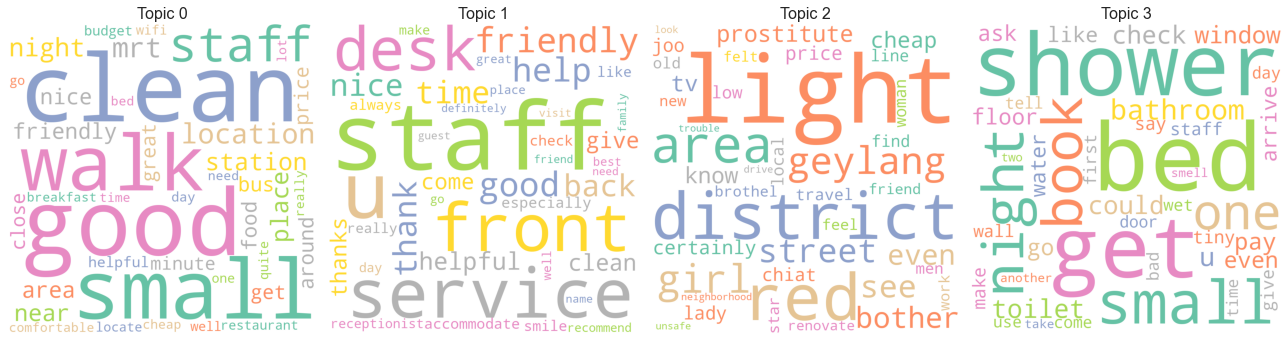

In [8]:
wordcloud_LDA(lda_model)

## Topic Allocation

`With this, topics words can be interpreted and topics can be allocated accordingly. 

**Topic Allocation**
- Topic 0 - Location  
- Topic 1 - Service 
- Topic 2 - Environment 
- Topic 3 - Room Amenities  

In [9]:
# Create a function to allocate the dominant topic to each review 
def format_topics_sent(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: x[1], reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords']
   
    contents = df['Review']
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Text"}, inplace=True)
    return sent_topics_df

In [10]:
topic_df = format_topics_sent(lda_model, doc_term_matrix, df)

In [11]:
topic_df

,Dominant_topic,Perc_Contrib,Topic_Keywords,Review
0,0.0,0.5293,"clean, good, small, walk, staff, location, mrt...",When they say budget they really mean budget. ...
1,1.0,0.3879,"staff, u, service, front, desk, friendly, good...",This hotel does not live up to expectation of ...
2,0.0,0.6708,"clean, good, small, walk, staff, location, mrt...",We stayed 4 nights. We got free room promotion...
3,0.0,0.6372,"clean, good, small, walk, staff, location, mrt...",Located in an area that looks a little more ru...
4,0.0,0.9890,"clean, good, small, walk, staff, location, mrt...",Ibis pearl is good budget hotel in geylang are...
...,...,...,...,...
3869,0.0,0.8436,"clean, good, small, walk, staff, location, mrt...",This hotel was located near Orchard road and m...
3870,0.0,0.8214,"clean, good, small, walk, staff, location, mrt...",Hotel is close to really good restaurants and ...
3871,1.0,0.8840,"staff, u, service, front, desk, friendly, good...","Beside the supper comfort, facilities and acco..."
3872,0.0,0.8333,"clean, good, small, walk, staff, location, mrt...",Great place to stay! ^_^ Walking distance to m...


In [12]:
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3874 entries, 0 to 3873
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Dominant_topic  3874 non-null   float64
 1   Perc_Contrib    3874 non-null   float32
 2   Topic_Keywords  3874 non-null   object 
 3   Review          3874 non-null   object 
dtypes: float32(1), float64(1), object(2)
memory usage: 106.1+ KB


In [13]:
# Convert data type of dominant topic to integer 
topic_df['Dominant_topic']= topic_df['Dominant_topic'].astype('int64')

In [14]:
topic_df.head()

,Dominant_topic,Perc_Contrib,Topic_Keywords,Review
0,0,0.5293,"clean, good, small, walk, staff, location, mrt...",When they say budget they really mean budget. ...
1,1,0.3879,"staff, u, service, front, desk, friendly, good...",This hotel does not live up to expectation of ...
2,0,0.6708,"clean, good, small, walk, staff, location, mrt...",We stayed 4 nights. We got free room promotion...
3,0,0.6372,"clean, good, small, walk, staff, location, mrt...",Located in an area that looks a little more ru...
4,0,0.9890,"clean, good, small, walk, staff, location, mrt...",Ibis pearl is good budget hotel in geylang are...


In [15]:
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...


In [16]:
# Merge the orginal df to the topic_df for overview and future analysis
final_df = df.merge(topic_df,left_index = True, right_index = True)

In [17]:
final_df = final_df.drop('Review_y', axis = 1)

In [18]:
final_df.rename(columns={'Review_x': 'Review'}, inplace=True)

In [19]:
final_df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review,Dominant_topic,Perc_Contrib,Topic_Keywords
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...,0,0.5293,"clean, good, small, walk, staff, location, mrt..."
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...,1,0.3879,"staff, u, service, front, desk, friendly, good..."
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...,0,0.6708,"clean, good, small, walk, staff, location, mrt..."
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...,0,0.6372,"clean, good, small, walk, staff, location, mrt..."
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...,0,0.9890,"clean, good, small, walk, staff, location, mrt..."


## 4. Sentiment Analysis with TextBlob 

After the underlying topics were sieved out and allocated to each review successfully, sentiment analysis will be performed using textBlobs for the reviews. This allows us to get a sensing of how the hotel guests feel about each topic in the EDA section. 

In [20]:
# Create a function to analysis sentiments of reviews using TextBlob
def sentiment_analysis(df):
 #Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Polarity’)
    df['TextBlob_Polarity'] = df['Review'].apply(getPolarity)
    
    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score >= 0.15:
            return 'Positive'
        else:
            return 'Neutral'
     
    df['Pol_Rating'] = df['TextBlob_Polarity'].apply(getAnalysis )

    return  df

In [21]:
sentiment_analysis(final_df)

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...,0,0.5293,"clean, good, small, walk, staff, location, mrt...",0.001923,Neutral
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...,1,0.3879,"staff, u, service, front, desk, friendly, good...",-0.077597,Negative
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...,0,0.6708,"clean, good, small, walk, staff, location, mrt...",0.120055,Neutral
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...,0,0.6372,"clean, good, small, walk, staff, location, mrt...",0.209201,Positive
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...,0,0.9890,"clean, good, small, walk, staff, location, mrt...",0.400000,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
3869,ibis budget Singapore Selegie,December 2016,"Accesible, but tiny rooms😓",This hotel was located near Orchard road and m...,3,Neutral,locate near orchard road midway little india s...,0,0.8436,"clean, good, small, walk, staff, location, mrt...",-0.077500,Negative
3870,ibis budget Singapore Selegie,September 2017,F1 weekend,Hotel is close to really good restaurants and ...,4,Positive,close really good restaurant local shop love s...,0,0.8214,"clean, good, small, walk, staff, location, mrt...",0.336111,Positive
3871,ibis budget Singapore Selegie,November 2017,Amazing hotel in the heart of Singapore,"Beside the supper comfort, facilities and acco...",4,Positive,beside supper comfort facility accomodations s...,1,0.8840,"staff, u, service, front, desk, friendly, good...",0.428472,Positive
3872,ibis budget Singapore Selegie,October 2017,Worth it <3,Great place to stay! ^_^ Walking distance to m...,5,Positive,great place walk distance mustafa one ride awa...,0,0.8333,"clean, good, small, walk, staff, location, mrt...",0.310417,Positive


### Allocate topics to the Dominant topic groups

In [22]:
topic_mapping = {0: 'Location', 1: 'Service', 2: 'Environment', 3: 'Room Amenities'}

final_df['Topic'] = final_df['Dominant_topic'].map(topic_mapping)

### Add Review Length as a column

In [23]:
final_df['Review_Len'] = final_df['Review'].apply(lambda x: len(str(x).split(" ")))
final_df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating,Topic,Review_Len
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...,0,0.5293,"clean, good, small, walk, staff, location, mrt...",0.001923,Neutral,Location,89
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...,1,0.3879,"staff, u, service, front, desk, friendly, good...",-0.077597,Negative,Service,54
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...,0,0.6708,"clean, good, small, walk, staff, location, mrt...",0.120055,Neutral,Location,98
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...,0,0.6372,"clean, good, small, walk, staff, location, mrt...",0.209201,Positive,Location,80
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...,0,0.9890,"clean, good, small, walk, staff, location, mrt...",0.400000,Positive,Location,53


### Add Year as a column

In [24]:
# Define function to exrtact year from Date column
def get_year(x):
    x = '20' + x[-2:]
    return x 

In [25]:
# Apply function
final_df ['Year'] = final_df['Date'].apply(get_year)

In [26]:
# Check if year is extracted correctly 
final_df['Year'].unique()

array(['2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015',
       '2014', '2013', '2012', '2011', '2010', '2009'], dtype=object)

In [27]:
final_df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating,Topic,Review_Len,Year
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...,0,0.5293,"clean, good, small, walk, staff, location, mrt...",0.001923,Neutral,Location,89,2022
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...,1,0.3879,"staff, u, service, front, desk, friendly, good...",-0.077597,Negative,Service,54,2021
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...,0,0.6708,"clean, good, small, walk, staff, location, mrt...",0.120055,Neutral,Location,98,2020
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...,0,0.6372,"clean, good, small, walk, staff, location, mrt...",0.209201,Positive,Location,80,2020
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...,0,0.9890,"clean, good, small, walk, staff, location, mrt...",0.400000,Positive,Location,53,2020


In [28]:
#Saving CSV for part 3 - Exploratory Data Analysis  
final_df.to_csv('final_df.csv', index = False)